<a href="https://colab.research.google.com/github/aaapetrova/DSP/blob/main/Petrova_lb1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа №1

Цель работы - практическое применение дискретного преобразования Фурье для анализа речевых сигналов.


## Требуется загрузить аудио с названием "audio_voice.wav"

In [48]:
#!wget https://github.com/aaapetrova/DSP/blob/9ccfb7ad86db18cafcb936cb4ae858370570d818/audio_voice.wav
path_to_wave = "/content/audio_voice.wav"

# Needed imports

In [41]:
# Needed imports
import numpy as np
from IPython.display import Audio
from scipy.io import wavfile
import matplotlib.pyplot as plt
from itertools import zip_longest


Sample rate: 48000 Hz
Total time: 3.96s


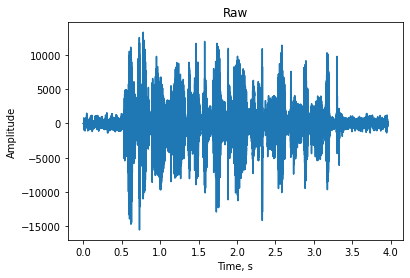

In [47]:
frame_rate, sound_data = wavfile.read(path_to_wave)
time                   = np.arange(0,len(sound_data))/frame_rate

sound_data = sound_data.T[0]
# Show information about the object
print('Sample rate:',frame_rate,'Hz')
print(f'Total time: {len(sound_data)/frame_rate}s')


plt.plot(time, sound_data)
plt.title("Raw")
plt.xlabel("Time, s")
plt.ylabel("Amplitude")

plt.show()

# Launch raw version of sound

In [4]:
Audio(sound_data,rate=frame_rate)

# Фильтр нижних частот (ФНЧ)

Фильтр нижних частот - фильтр, эффективно пропускающий частотный спектр сигнала ниже некоторой частоты (частоты среза) и подавляющий частоты сигнала выше этой частоты.

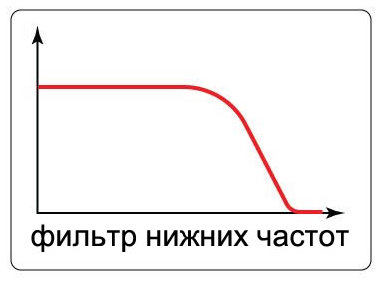

In [5]:
Fd = frame_rate # частота дискретизации
Fs = frame_rate / 100 # частота среза
m = 1 # порядок фильтра - описывает скорость затухания сигнала после частоты среза
wn = 2 * Fs/ Fd # 

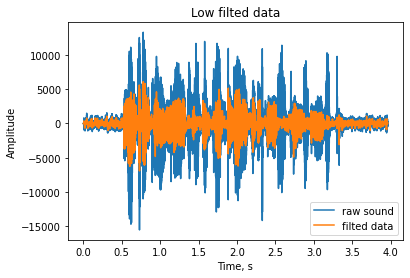

In [6]:
# не знаю можно ли так делать
from scipy import signal

def filter_low_pass(FD, FS, m, data):
    wn = 2 * FS/ FD
    b, a = signal.butter(m, wn, 'lowpass')
    return signal.filtfilt(b, a, data)

filtedData = filter_low_pass(Fd, Fs, m, sound_data)

fig, ax = plt.subplots()
plt.title("Low filted data")
plt.xlabel("Time, s")
plt.ylabel("Amplitude")
ax.plot(time, sound_data, label = 'raw sound')
ax.plot(time, filtedData, label = 'filted data')
ax.legend()
plt.show()

Audio(filtedData,rate=frame_rate)

# ЭХО

$\cdot$ Ревербератор реализован, как набор линий задержки. Число линий задержки $N_{L} \geq 8$. Каждая линия задержки имеет свой весовой коэффициент (задается пользователем): 
$ \alpha_{1} > \alpha_{2} > \dots > \alpha_{N_{L}}$.

$\cdot$ Перед добавлением к исходному сигналу, выход ревербератора фильтруется ФНЧ-фильтром первого порядка.

$\cdot$ Желаемое соотношение между ”сухим” и обработанным сигналом задается коэффициентом применимости $\gamma$.

$\cdot$ Ревербератор может работать в двух режимах: ручной и с использованием готовой конфигурации (preset). Для ручного режима регулируется пользователем задается максимальная задержка $D_1$ , а величины остальных определяются автоматически через нее:

$D_i = D_1 2 \frac{1-i} {N_L}, i = 2, \dots, N_L$.

Для готовой конфигурации пользователь вручную задает последовательность $D_1 > D_2 > \dots > D_{N_L}$.

За основу эффекта эхо был использован ревербератор
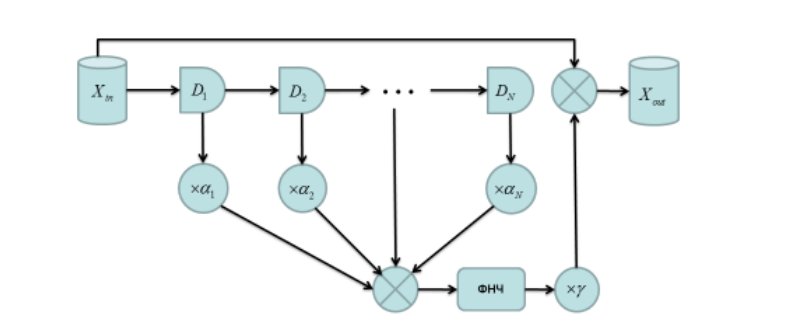

In [16]:
Nl = 8
DISTANCE = 300 # метров
time_to_wall = DISTANCE / 335 # СКОРОСТЬ ЗВУКА
D1 = frame_rate * time_to_wall
gamma = 0.2
D1

42985.07462686567

In [34]:
D = [int(D1 * 2 ** ((1 - i)/Nl)) for i in range(1, Nl +1)]
alpha = [np.exp(-i/5) for i in range(0, Nl)]

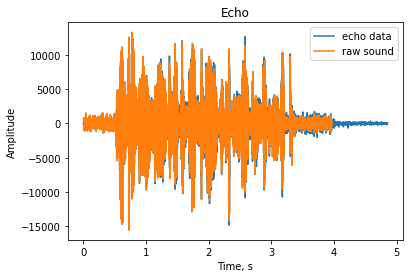

In [38]:
delays = [[0 for j in range(i)] + list(sound_data) for i in D]
delays = [ [i*alpha[idx] for i in val] for idx, val in enumerate(delays) ]

sum_delays = [sum(x) for x in zip_longest(*delays, fillvalue=0)]
#filted_data = filter_low_pass(Fd, Fs, 1, sum_delays)
gammas = [i*gamma for i in filter_low_pass(Fd, Fs, 1, sum_delays)]

echo_voice = [sum(x) for x in zip_longest(gammas, sound_data, fillvalue=0)] 
time_echo = np.linspace(0, len(echo_voice)/Fd, num=len(echo_voice))
fig, ax = plt.subplots()
plt.title("Echo")
plt.xlabel("Time, s")
plt.ylabel("Amplitude")
ax.plot(time_echo, echo_voice, label = 'echo data')
ax.plot(time, sound_data, label = 'raw sound')
ax.legend()
plt.show()

Audio(echo_voice,rate=frame_rate)

# Distortion

Обозначим входной сигнал и выходной сигналы - $x(i)$ и $y(i)$ соответственно. $i = 0,1, \dots, N − 1$.

Пользователь задает порог — $Th$ и максимальное значение сигнала $ Max > Th$. Тогда $y(i) = \begin{cases} x(i), |x(i)| \leq Th, \\ Max * sign(x(i)), |x(i)| &gt; Th\end{cases}$

In [ ]:
TH = 10000 # ПОРОГ
MAX = 30000 # МАКСМАЛЬНОЕ ЗНАЧЕНИЕ


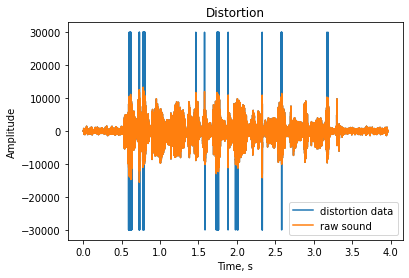

In [ ]:
distortion_data = []
for i in sound_data:
  if abs(i) <= TH:
    value = i
  else:
    value = MAX * (-1 if i < 0 else 1)
  distortion_data.append(value)

fig, ax = plt.subplots()
plt.title("Distortion")
plt.xlabel("Time, s")
plt.ylabel("Amplitude")
ax.plot(time, distortion_data, label = 'distortion data')
ax.plot(time, sound_data, label = 'raw sound')
ax.legend()
plt.show()

Audio(np.array(distortion_data, dtype=np.int16),rate=frame_rate)

# Вывод

по ходу выполнения лабораторной работы были изучены возможности библиотек Python, такие как scipy, numpy. Был изучен фильтр нижних частот, дисторсия и эффект эхо.